In [1]:
import sys
assert sys.version_info >= (3, 5)

# is this notebook running on colab or Kaggle
IS_COLAB = 'google_colab' in sys.modules
IS_KAGGLE = 'kaggle_secret' in sys.modules

# scikit_learn >= 0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

#tensorflow >= 2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__>= '0.20'

if not tf.config.list_physical_devices('GPU'):
  print('No GPU was detected LSTM and CNNs can be very slow without a GPU')
  if IS_COLAB:
    print('Go to Runtime > change runtime and select a GPU hardware accelerator')
  if IS_KAGGLE:
    print('Go to setting > Accelerator and select GPU')

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize = 14)
mpl.rc('xtick', labelsize = 12)
mpl.rc('ytick', labelsize = 12)

In [2]:
#RNN co ban
# tao tap du lieu
def generate_time_series(batch_size, n_steps):
  freq1, freq2, offset1, offset2 = np.random.rand(4, batch_size, 1)
  time = np.linspace(0, 1, n_steps)
  series = 0.5 *np.sin(( time - offset1 ) * (freq1 * 10 + 10)) # wave1
  series += 0.2 * np.sin(( time - offset2) * (freq2 * 20 + 20)) #wave2
  series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5) # noise
  return series[..., np.newaxis].astype(np.float32)


In [3]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, : n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

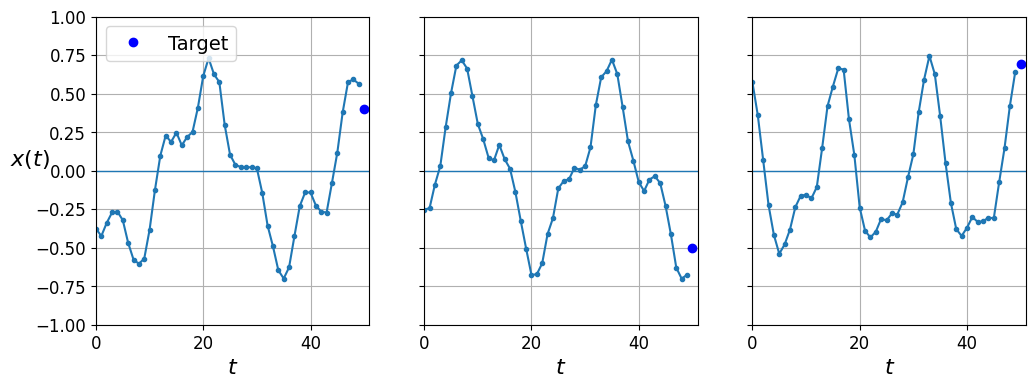

In [5]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
plt.savefig("time_series_plot")
plt.show()


In [6]:
# du doan tho ngay
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

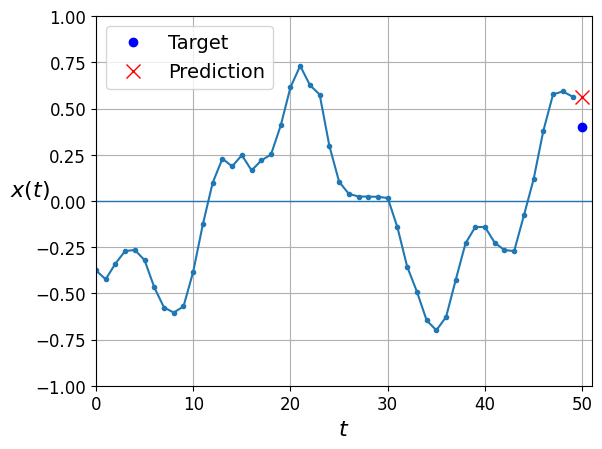

In [7]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [8]:
# du doan tuyen tinh
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [50, 1]),
    keras.layers.Dense(1)
])
model.compile(loss = 'mse', optimizer  ='adam')
history = model.fit(X_train, y_train, epochs  =20,
                    validation_data = (X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 10s 15ms/step - loss: 0.1147 - val_loss: 0.0633
Epoch 2/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0469 - val_loss: 0.0350
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0282 - val_loss: 0.0232
Epoch 4/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0202 - val_loss: 0.0180
Epoch 5/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0162 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0136 - val_loss: 0.0130
Epoch 7/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0117 - val_loss: 0.0112
Epoch 8/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0101 - val_loss: 0.0097
Epoch 9/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0088 - val_loss: 0.0086
Epoch 10/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0077 - val_loss: 0.

In [9]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0043


0.0042523168958723545

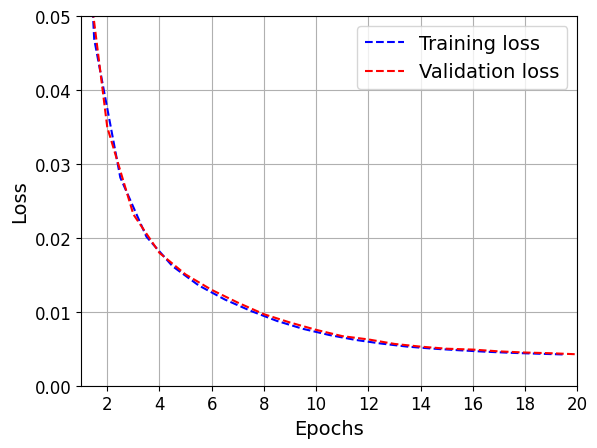

In [10]:
def plot_learning_curves(loss, val_loss):
  plt.plot(np.arange(len(loss)) + 0.5, loss, 'b--', label = "Training loss")
  plt.plot(np.arange(len(val_loss)) + 1, val_loss, 'r--', label = 'Validation loss')
  plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
  plt.axis([1, 20, 0, 0.05])
  plt.legend(fontsize =14)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.grid(True)

plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

In [11]:
# su dung 1 RNN don gian
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])
optimizer = keras.optimizers.Adam(learning_rate = 0.05)
model.compile(loss = 'mse', optimizer = optimizer)
history = model.fit(X_train, y_train, epochs = 20,
                    validation_data = (X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 9s 38ms/step - loss: 0.0354 - val_loss: 0.0110
Epoch 2/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0115 - val_loss: 0.0108
Epoch 3/20
219/219 [==============================] - 9s 39ms/step - loss: 0.0115 - val_loss: 0.0111
Epoch 4/20
219/219 [==============================] - 7s 33ms/step - loss: 0.0116 - val_loss: 0.0109
Epoch 5/20
219/219 [==============================] - 8s 37ms/step - loss: 0.0115 - val_loss: 0.0108
Epoch 6/20
219/219 [==============================] - 8s 37ms/step - loss: 0.0116 - val_loss: 0.0113
Epoch 7/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0115 - val_loss: 0.0122
Epoch 8/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0116 - val_loss: 0.0114
Epoch 9/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0116 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 8s 37ms/step - loss: 0.0116 - val_lo

In [12]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 6ms/step - loss: 0.0109


0.010852129198610783

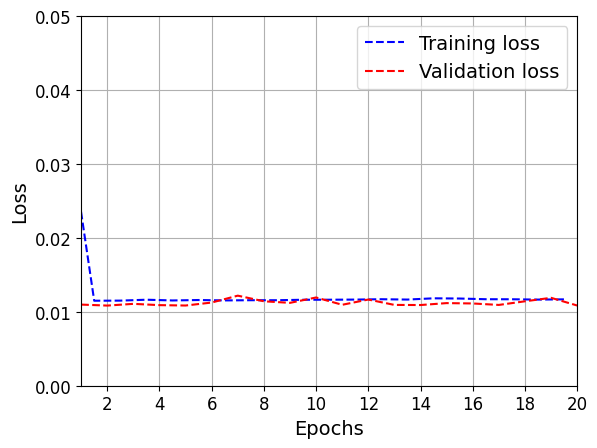

In [13]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

63/63 [==============================] - 0s 5ms/step


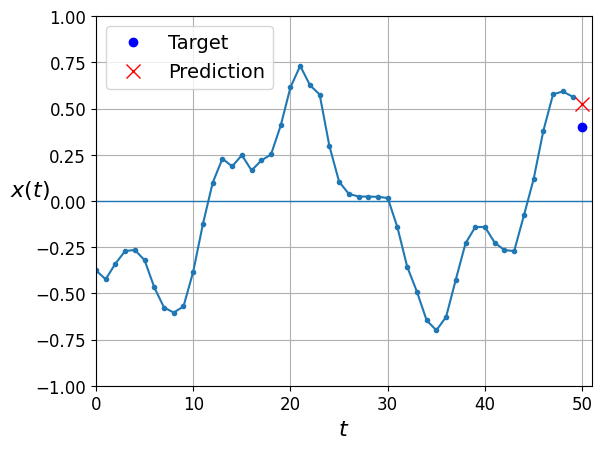

In [14]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [ ]:
# RNN sau
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape = [None, 1]),
    keras.layers.SimpleRNN(20, return_sequences = True),
    keras.layers.SimpleRNN(1)
])
model.compile(loss = 'mse', optimizer = 'adam')
history = model.fit(X_train, y_train, epochs  =20,
                    validation_data = (X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 34s 136ms/step - loss: 0.0773 - val_loss: 0.0093
Epoch 2/20
219/219 [==============================] - 30s 139ms/step - loss: 0.0072 - val_loss: 0.0059
Epoch 3/20
219/219 [==============================] - 31s 139ms/step - loss: 0.0058 - val_loss: 0.0044
Epoch 4/20
219/219 [==============================] - 30s 137ms/step - loss: 0.0047 - val_loss: 0.0039
Epoch 5/20
219/219 [==============================] - 30s 139ms/step - loss: 0.0046 - val_loss: 0.0042
Epoch 6/20
219/219 [==============================] - 30s 136ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 7/20
219/219 [==============================] - 30s 137ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 8/20
219/219 [==============================] - 31s 142ms/step - loss: 0.0037 - val_loss: 0.0041
Epoch 9/20
219/219 [==============================] - 30s 135ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 10/20
219/219 [==============================] - 31s 140ms/step - l

In [ ]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 13ms/step - loss: 0.0027


0.00266060559079051

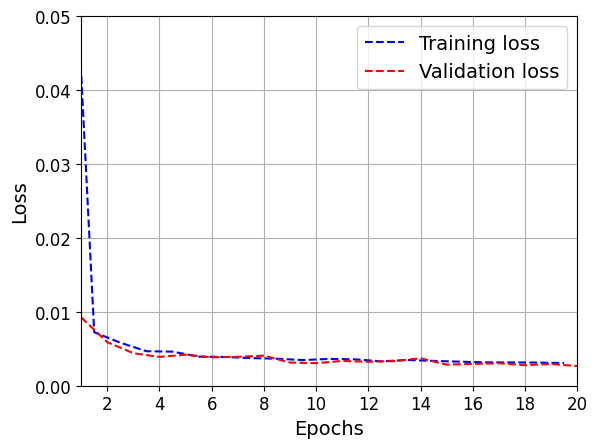

In [ ]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

63/63 [==============================] - 1s 12ms/step


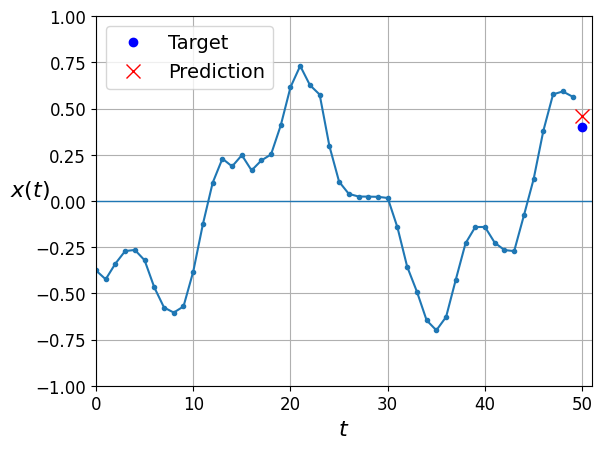

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [ ]:
# du bao truoc 1 vai buoc
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

1/1 [==============================] - 0s 27ms/step


In [ ]:
y_pred.shape

(2000, 1)

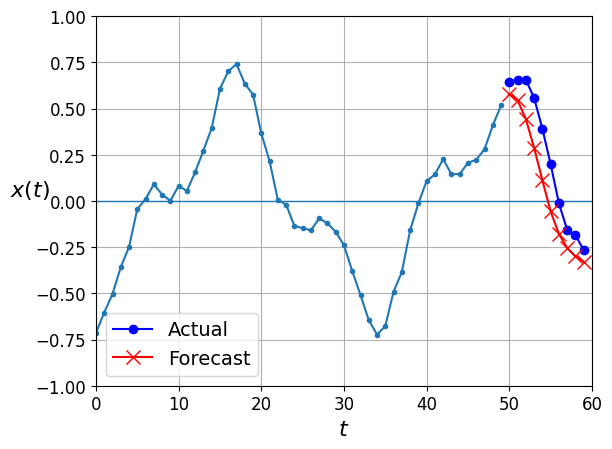

In [ ]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.savefig("forecast_ahead_plot")
plt.show()

In [ ]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps+10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10, 0]

In [ ]:
# du doan 10 gia tri tiep theo
X = X_valid
for step_ahead in range (10):
  y_pred_one = model.predict(X)[:, np.newaxis, :]
  X = np.concatenate([X, y_pred_one], axis = 1)

y_pred = X[:, n_steps:, 0]

63/63 [==============================] - 1s 14ms/step


In [ ]:
y_pred.shape

(2000, 10)

In [ ]:
Y_naive_pred = np.tile(X_valid[:, -1], 10)
np.mean(keras.metrics.mean_squared_error(y_valid, Y_naive_pred))

0.47568396

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [50, 1]),
    keras.layers.Dense(10)
])
model.compile(loss = 'mse', optimizer  ='adam')
history = model.fit(X_train, Y_train, epochs = 20,
                    validation_data = (X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 2s 6ms/step - loss: 0.1304 - val_loss: 0.0629
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0507 - val_loss: 0.0432
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0387 - val_loss: 0.0356
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0333 - val_loss: 0.0315
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0300 - val_loss: 0.0288
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0278 - val_loss: 0.0271
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0262 - val_loss: 0.0256
Epoch 8/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0250 - val_loss: 0.0244
Epoch 9/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0240 - val_loss: 0.0236
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0232 - val_loss: 0.0228

In [ ]:
# tao 1 RNN du doan 10 gia tri lien tiep cung luc
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape = [None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])
model.compile(loss = 'mse', optimizer = 'adam')
history = model.fit(X_train, Y_train, epochs = 20,
                    validation_data = (X_valid, Y_valid))

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [ ]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [ ]:
X_train.shape, Y_train.shape

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape = [None, 1]),
    keras.layers.SimpleRNN(20, return_sequences = True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])
def last_time_step_mse(Y_true, Y_pred):
  return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs = 20,
                    validation_data = (X_valid, Y_valid))

In [ ]:
np.random.seed(43)
series = generate_time_series(1, 50+10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [ ]:
# RNN chuan hoa theo batch
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape = [None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss = 'mse', optimizer = 'adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs= 20,
                    validation_data = (X_valid, Y_valid))

In [ ]:
from tensorflow.keras.layers import LayerNormalization, SimpleRNNCell

class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation='tanh', **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = SimpleRNNCell(units, activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]


In [ ]:
model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences = True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])
model.compile(loss = 'mse', optimizer='adam', metrics = [last_time_step_mse])
history = model.fit(X_train, Y_train, epochs = 20,
                    validation_data=(X_valid, Y_valid))

In [ ]:
class MyRNN(keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.get_initial_state = getattr(
            self.cell, "get_initial_state", self.fallback_initial_state)
    def fallback_initial_state(self, inputs):
        batch_size = tf.shape(inputs)[0]
        return [tf.zeros([batch_size, self.cell.state_size], dtype=inputs.dtype)]
    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        shape = tf.shape(inputs)
        batch_size = shape[0]
        n_steps = shape[1]
        sequences = tf.TensorArray(
            inputs.dtype, size=(n_steps if self.return_sequences else 0))
        outputs = tf.zeros(shape=[batch_size, self.cell.output_size], dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)
        if self.return_sequences:
            return tf.transpose(sequences.stack(), [1, 0, 2])
        else:
            return outputs

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    MyRNN(LNSimpleRNNCell(20), return_sequences=True,
          input_shape = [None, 1]),
    MyRNN(LNSimpleRNNCell(20), return_sequences = True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])
model.compile(loss = 'mse', optimizer = 'adam', metrics=[last_time_step_mse])
history = model.fit(X_train,Y_train,epochs = 20,
                    validation_data = (X_valid, Y_valid))

In [ ]:
# LSTM
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape = [None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])
model.compile(loss = 'mse', optimizer = 'adam', metrics = [last_time_step_mse])
history = model.fit(X_train, Y_train, epochs = 20,
                    validation_data = (X_valid, Y_valid))

In [ ]:
model.evaluate(X_valid, Y_valid)

In [ ]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

In [ ]:
np.random.seed(43)
series = generate_time_series(1, 50+10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [ ]:
# GRU
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences = True, input_shape = [None, 1]),
    keras.layers.GRU(20, return_sequences = True),
    keras.layer.TimeDistributed(keras.layers.Dense(10))
  ])

model.compile(loss = 'mse', optimizer = 'adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs = 20,
                    validation_data = (X_valid, Y_valid))

In [ ]:
model.evaluate(X_valid, Y_valid)

In [ ]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

In [ ]:

np.random.seed(43)
series = generate_time_series(1, 50+10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]